#### Import libraries

In [1]:
from glob import glob
import numpy as np
import numpy.random as npr
import sklearn
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import linalg as la
from keras import regularizers
from keras import backend as K
from keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Input,
    Flatten,
    Dense,
    Lambda,
    Reshape,
)


2023-06-12 11:25:13.405269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 11:25:14.108678: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-12 11:25:14.108743: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-12 11:25:14.108750: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

#### Set parameters

In [2]:
npr.seed(28980)

dim = 2
numpart = 30
latent_dim = 40
box_size = 10


n_comps=20
n_samples=10

#### Define class and create instance

In [3]:
reg_lambda = 0.00035

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Extract dimensions excluding the first 'None' dimension
            size = reconstruction.shape[1:]

            # Reshape data to match decoder output shape
            data = tf.expand_dims(data, axis=-1)

            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + reg_lambda * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [4]:
encoder = keras.models.load_model("./saved-models/encoder")
decoder = keras.models.load_model("./saved-models/decoder")

vae = VAE(encoder, decoder)

2023-06-12 11:25:15.957810: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-12 11:25:15.957834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (davide-PC): /proc/driver/nvidia/version does not exist
2023-06-12 11:25:15.958685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Helper functions

In [5]:
def gram_to_coordinates(distance_matrix):
    # Get the number of points
    n = distance_matrix.shape[0]

    # Compute the Gram matrix
    gram_matrix = -0.5 * (distance_matrix**2)

    # Center the Gram matrix
    gram_matrix_centered = (
        gram_matrix
        - np.mean(gram_matrix, axis=0)
        - np.mean(gram_matrix, axis=1)[:, np.newaxis]
        + np.mean(gram_matrix)
    )

    # Perform eigendecomposition of the centered Gram matrix
    eigenvalues, eigenvectors = np.linalg.eigh(gram_matrix_centered)

    # Sort eigenvalues and eigenvectors in descending order
    indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:, indices]

    # Extract the positive square root of eigenvalues
    sqrt_eigenvalues = np.sqrt(np.maximum(eigenvalues, 0))

    # Compute the coordinates of the points in 2D space
    coordinates = eigenvectors[:, :2] * sqrt_eigenvalues[:2]

    return coordinates


In [6]:
def find_best_params(points):
    init_trans = np.mean(points, axis=0)
    centered_points = points - init_trans

    def sign(x):
        if x > 0:
            return 1
        if x < 0:
            return -1
        return 0

    # order by distance form the center
    centered_points = np.array(
        sorted(
            centered_points,
            key=lambda x: x[0] ** 2 + x[1] ** 2,
            reverse=True,
        )
    )
    # take 3 furthest
    selected_points = [centered_points[i] for i in range(3)]

    selected_points = sorted(
        selected_points, key=lambda x: np.arctan2(x[1], x[0])
    )

    # going in decreasing distance order, check if each successive point is
    ##  within the poligon with the currently selected point as vertices
    for p in centered_points[3:]:
        inside = True
        for j in range(len(selected_points)):
            p1 = selected_points[j]
            p2 = selected_points[j - 1]

            norm = np.array([p1[1] - p2[1], p2[0] - p1[0]])
            centr = (p1 + p2) / 2

            if sign(np.dot(p - centr, norm)) > 0:
                inside = False
                break

        if not inside:
            # if not in poligon, select the point
            selected_points.append(p)
            selected_points = sorted(
                selected_points, key=lambda x: np.arctan2(x[1], x[0])
            )
    
    while True:
        for i in range(len(selected_points)):
            p3=selected_points[i]
            p2=selected_points[i-1]
            p1=selected_points[i-2]
            
            norm = np.array([p1[1] - p3[1], p3[0] - p1[0]])
            centr = (p1 + p3) / 2
            if sign(np.dot(p2 - centr, norm)) > 0:
                break
        else:
            break
        del selected_points[i-1]
    
    # find the polygon segment that is closer to the center
    # selected_points = sorted(selected_points, key=lambda x: np.arctan2(x[1], x[0]))
    dists = [0 for i in range(len(selected_points))]
    for i in range(len(selected_points)):
        p1 = selected_points[i]
        p2 = selected_points[i - 1]

        norm = np.array([p1[1] - p2[1], p2[0] - p1[0]])
        # print((norm[0]**2+norm[1]**2)**0.5, p1, p2, selected_points)
        norm /= (norm[0] ** 2 + norm[1] ** 2) ** 0.5
        centr = (p1 + p2) / 2
        dists[i] = np.abs(np.dot(centr, norm))

    c_ind = dists.index(min(dists))  # index of closest segment

    # turn points so that segment faces down
    p1 = selected_points[c_ind]
    p2 = selected_points[c_ind - 1]
    norm = np.array([p1[1] - p2[1], p2[0] - p1[0]])

    ##plt.scatter([i[0] for i in centered_points],[i[1] for i in centered_points], c="blue")
    ##plt.scatter([i[0] for i in selected_points],[i[1] for i in selected_points], c="#00ff00", s=10)

    theta = np.pi * 3 / 2 - np.arctan2(norm[1], norm[0])
    rot_mat = np.array(
        [[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]
    )

    centered_points = centered_points @ rot_mat
    selected_points = np.array(selected_points) @ rot_mat
    # shift in place
    selected_points -= centered_points.min(axis=0)
    centered_points -= centered_points.min(axis=0)
    return centered_points, selected_points



In [7]:
def display_matrix(mat, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    
    df = pd.DataFrame(mat)
    sns.heatmap(df, ax=ax)

#### Get data for PCA

In [8]:
dump_dir = "../mc-sampling/good-runs/"
# read all position files in chosen directory
files = glob(dump_dir + "gamma*_10000_*_x.txt")
# sort files by gamma value
files = np.array(files)[np.argsort([f.split("_")[1] for f in files])]
gamma = np.sort([f.split("_")[1] for f in files]).astype(float)

num_gammas = files.size
arrays = [np.loadtxt(f) for f in files]

# combine data + reshape, and assign labels to different datasets
data = np.vstack(arrays)
vcs = data.reshape((-1, numpart, dim)) / (box_size * np.sqrt(dim))
labels = np.hstack([[i] * len(a) for i, a in enumerate(arrays)])

sort_idx = np.argsort(vcs[:, :, 0] ** 2 + vcs[:, :, 1] ** 2)
sorted_vcs = np.array(
    [sample[sort_idx[i]] for i, sample in enumerate(vcs)]
)

dm = np.array([squareform(pdist(sample)) for sample in sorted_vcs])

encoded_data = np.array(vae.encoder.predict(dm))
del dm, sorted_vcs, arrays, sort_idx

pca=PCA(n_components=n_comps)
pca.fit(encoded_data[0, :, :])

1250/1250 [==============================] - 23s 18ms/step


PCA(n_components=20)

In [10]:

cov_mat=pca.get_covariance()
rdata=pca.inverse_transform(np.random.normal(0,[cov_mat[i][i] for i in range(n_comps)], size=(n_samples,n_comps)))
rdata=rdata+np.random.normal(0, 0.05, size=(n_samples, latent_dim))
decoded_test = np.array(decoder.predict(rdata)).reshape(
    -1, numpart, numpart
)

1/1 [==============================] - 0s 103ms/step


In [11]:
coords=[gram_to_coordinates(d) for d in decoded_test]

In [12]:
new = [find_best_params(i) for i in coords]

points = np.array([i[0] for i in new])
selections = [np.array(i[1]) for i in new]

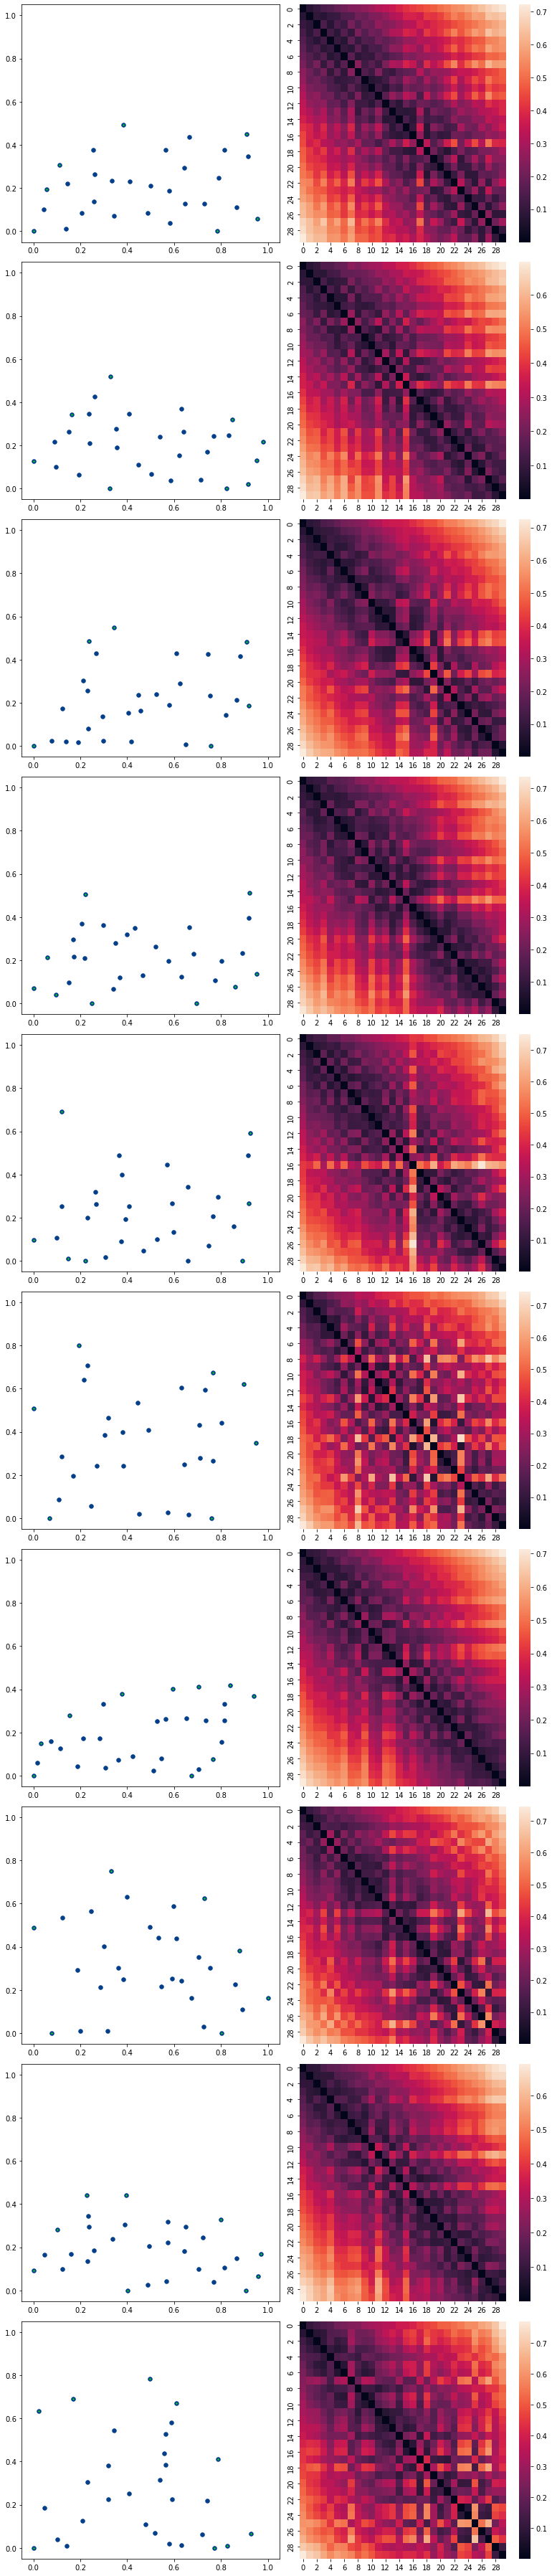

In [13]:
fig,ax = plt.subplots(ncols=2, nrows=n_samples,figsize=(11, 5*n_samples))

l = np.sqrt(2)
for ind in range(n_samples):
    ax[ind][0].scatter(
        points[ind, :, 0] * l,
        points[ind, :, 1] * l,
        s=30,
        c="#023e8a",
    )
    ax[ind][0].scatter(
        selections[ind][:, 0] * l,
        selections[ind][:, 1] * l,
        s=5,
        marker=".",
        c="#00ff00",
    )
    ax[ind][0].set_ylim(-0.05,1.05)
    ax[ind][0].set_xlim(-0.05,1.05)
    display_matrix(decoded_test[ind], ax[ind][1])
fig.tight_layout()
plt.show()
